In [1]:
from rdkit import Chem
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 6
# plt.rcParams['font.sans-serif'] = 'Arial'
from easie.utils.prop_conv_utils import *
from rdkit.Chem import AllChem, Descriptors, Lipinski, rdMolDescriptors

In [2]:
with open('outputs/26Aug2023_corrected_mitapivat_experimental_route_leaf_info.json', 'r') as f:
    leaves = json.load(f)

In [3]:
orig_reactants = [Chem.MolFromSmiles(leaf['smiles']) for leaf in leaves]
p_mol = Chem.MolFromSmiles('O=C(C1=CC=C(NS(=O)(C2=CC=CC3=C2N=CC=C3)=O)C=C1)N(CC4)CCN4CC5CC5')

In [4]:
all_options = set.union(*[set(leaf['options']) for leaf in leaves])
prop_dict = {s:{'mol':Chem.MolFromSmiles(s)} for s in all_options}

for s in prop_dict:
    mol = prop_dict[s]['mol']
    prop_dict[s]['tpsa'] = Descriptors.TPSA(mol) 
    prop_dict[s]['rot_bonds'] = rdMolDescriptors.CalcNumRotatableBonds(mol)
    prop_dict[s]['MW'] = Chem.rdMolDescriptors.CalcExactMolWt(mol)
    prop_dict[s]['fp'] = np.array(get_morgan_fingerprint(mol)).astype(bool)
    prop_dict[s]['h_donors'] = Lipinski.NumHDonors(mol) 
    prop_dict[s]['h_acceptors'] = Lipinski.NumHAcceptors(mol)
    prop_dict[s]['logp'] = Descriptors.MolLogP(mol) 

In [5]:
h_donors_correction = Lipinski.NumHDonors(p_mol) - np.sum([Lipinski.NumHDonors(x) for x in orig_reactants])
h_acceptors_correction = Lipinski.NumHAcceptors(p_mol) - np.sum([Lipinski.NumHAcceptors(x) for x in orig_reactants])
logp_correction = Descriptors.MolLogP(p_mol) - np.sum([Descriptors.MolLogP(x) for x in orig_reactants])
mw_correction =  Chem.rdMolDescriptors.CalcExactMolWt(p_mol) - np.sum([Chem.rdMolDescriptors.CalcExactMolWt(x) for x in orig_reactants])
rot_bonds_correction = Chem.rdMolDescriptors.CalcNumRotatableBonds(p_mol) - np.sum([Chem.rdMolDescriptors.CalcNumRotatableBonds(x) for x in orig_reactants])
tpsa_correction = Descriptors.TPSA(p_mol) - np.sum([Descriptors.TPSA(x) for x in orig_reactants])    

In [6]:
props = list(prop_dict[s].keys())

226.980777112
Total size of space: 875989622
Molecules within bounds: 334004230
Molecules out of bounds: 541985392
Total size of space: 838495232
Molecules within bounds: 334004230
Molecules out of bounds: 504491002
Total size of space: 775670980
Molecules within bounds: 333996391
Molecules out of bounds: 441674589
Total size of space: 542080224
Molecules within bounds: 317564588
Molecules out of bounds: 224515636
Total size of space: 82353453
Molecules within bounds: 82343324
Molecules out of bounds: 10129


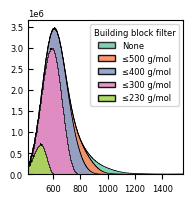

In [7]:
mw_filt = lambda f, x: x < f
plt.figure(figsize=(2,2))
min_mw = np.max([prop_dict[l['smiles']]['MW'] for l in leaves])
cmap = plt.get_cmap('Set2')
print (min_mw)

mw_xstart, mw_xcutoff = plot_dists(leaves, prop_dict, 'MW', 1, mw_correction, lb=200, ub=600, col=cmap(0), alpha=0.8, label="None")
for i, cutoff in enumerate([500,400,300,230]):
    plot_dists(leaves, prop_dict, 'MW', 1, mw_correction, lb=200, ub=600, 
               bb_prop_filter=lambda x: mw_filt(cutoff, x), col=cmap(i+1), alpha=0.9, label="≤{} g/mol".format(cutoff))

plt.xlim(mw_xstart, mw_xcutoff)
legend = plt.legend(title="Building block filter")
for patch in legend.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

52.32
Total size of space: 875989622
Molecules within bounds: 439430892
Molecules out of bounds: 436558730
Total size of space: 837285960
Molecules within bounds: 439430892
Molecules out of bounds: 397855068
Total size of space: 775928470
Molecules within bounds: 438157878
Molecules out of bounds: 337770592
Total size of space: 471326106
Molecules within bounds: 369377062
Molecules out of bounds: 101949044
Total size of space: 247498446
Molecules within bounds: 233880172
Molecules out of bounds: 13618274


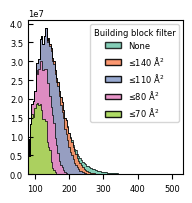

In [8]:
tpsa_filt = lambda f, x: x < f
plt.figure(figsize=(2,2))
min_tpsa = np.max([prop_dict[l['smiles']]['tpsa'] for l in leaves])
cmap = plt.get_cmap('Set2')
print (min_tpsa)

tpsa_xstart, tpsa_xcutoff = plot_dists(leaves, prop_dict, 'tpsa', 4, tpsa_correction, lb=75, ub=140, col=cmap(0), alpha=0.8, label="None")
for i, cutoff in enumerate([140,110,80,70]):
    plot_dists(leaves, prop_dict, 'tpsa', 4, tpsa_correction, lb=75, ub=140, 
               bb_prop_filter=lambda x: tpsa_filt(cutoff, x), col=cmap(i+1), alpha=0.9, label=r"≤{} Å$^2$".format(cutoff))

plt.xlim(tpsa_xstart, tpsa_xcutoff)
legend = plt.legend(title="Building block filter")
for patch in legend.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

2.1623
Total size of space: 875989622
Molecules within bounds: 207486486
Molecules out of bounds: 668503136
Total size of space: 572371100
Molecules within bounds: 198602101
Molecules out of bounds: 373768999
Total size of space: 464026080
Molecules within bounds: 189315080
Molecules out of bounds: 274711000
Total size of space: 372214400
Molecules within bounds: 185865790
Molecules out of bounds: 186348610
Total size of space: 291646574
Molecules within bounds: 159280972
Molecules out of bounds: 132365602


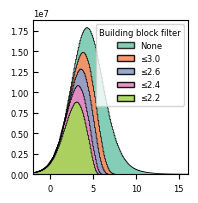

In [9]:
logp_filt = lambda f, x: x < 3 * f
plt.figure(figsize=(2,2))
min_logp = np.max([prop_dict[l['smiles']]['logp'] for l in leaves])
min_logp_filt = lambda x: x<=min_logp
cmap = plt.get_cmap('Set2')
logp_filt = lambda f, x: x < f
min_logp = np.max([prop_dict[l['smiles']]['logp'] for l in leaves])
cmap = plt.get_cmap('Set2')
print (min_logp)

logp_xstart, logp_xcutoff = plot_dists(leaves, prop_dict, 'logp', 0.1, logp_correction, lb=-5, ub=3, col=cmap(0), alpha=0.8, label="None")
for i, cutoff in enumerate([3,2.6,2.4,2.2]):
    plot_dists(leaves, prop_dict, 'logp', 0.1, logp_correction, lb=-5, ub=3, 
               bb_prop_filter=lambda x: logp_filt(cutoff, x), col=cmap(i+1), alpha=0.9, label=r"≤{:.1f}".format(cutoff))

plt.xlim(logp_xstart, logp_xcutoff+5)
legend = plt.legend(title="Building block filter")
for patch in legend.get_patches():
    patch.set_edgecolor('black')
    patch.set_linewidth(1)


In [10]:
leaf_tpsa = {}
leaf_mw = {}
leaf_logp = {}
for leaf in leaves:
    leaf_smiles = leaf['smiles']
#     if leaf_smiles != 'O=S(=O)(Cl)c1cccc2ncccc12':
    print (leaf_smiles)
    options= leaf['options']
    leaf_tpsa[leaf_smiles] = [prop_dict[s]['tpsa'] for s in options]
    leaf_mw[leaf_smiles]= [prop_dict[s]['MW'] for s in options]
    leaf_logp[leaf_smiles]= [prop_dict[s]['logp'] for s in options]

O=S(=O)(Cl)c1cccc2cccnc12
CCOC(=O)c1ccc(N)cc1
C1CN(CC2CC2)CCN1


(0.0, 150.0)

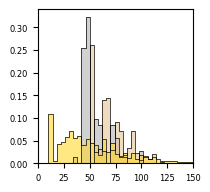

In [11]:
step_size = 4
plt.figure(figsize=(2,2))
for i, smiles in enumerate(leaf_tpsa):
    dist = prop_list_to_dist(leaf_tpsa[smiles],step_size)
    plt.bar(dist[1][:-1], dist[0]/np.sum(dist[0]), width=step_size, label=smiles, alpha=0.6, color=cmap(7-i))
    plot_outline(dist[1][:-1], dist[0]/np.sum(dist[0]), step_size=step_size)
plt.xlim(0,150)

(0.0, 1000.0)

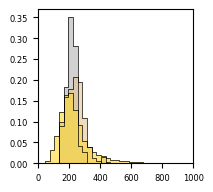

In [12]:
step_size = 30
plt.figure(figsize=(2,2))
for i, smiles in enumerate(leaf_mw):
    dist = prop_list_to_dist(leaf_mw[smiles],step_size)
    plt.bar(dist[1][:-1], dist[0]/np.sum(dist[0]), width=step_size, label=smiles, alpha=0.6, color=cmap(7-i))
    plot_outline(dist[1][:-1], dist[0]/np.sum(dist[0]), step_size=step_size)

plt.xlim(0,1000)

(-5.0, 6.0)

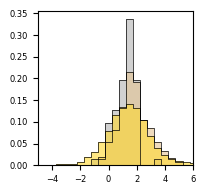

In [13]:
step_size = 0.5
plt.figure(figsize=(2,2))
for i, smiles in enumerate(leaf_logp):
    dist = prop_list_to_dist(leaf_logp[smiles],step_size)
    plt.bar(dist[1][:-1], dist[0]/np.sum(dist[0]), width=step_size, label=smiles, alpha=0.6, color=cmap(7-i))
    plot_outline(dist[1][:-1], dist[0]/np.sum(dist[0]), step_size=step_size)
plt.xlim(-5,6)

In [14]:
leaves[0]['query']

'[#7;a:1]:[c:2]:[c:3]-[S;H0;D4;+0:4](-[Cl;H0;D1;+0])(=[O;D1;H0:5])=[O;D1;H0:6]'